# Building a Neural Network from scratch

## Contents
1. [The Problem](#problem)
2. [Linear Model](#linear_mod)
    1. [Definition](#linear_def)
    2. [Training](#linear_train)
    3. [Implementation](#linear_imp)
3. [Neural Network Model](#neural_net)
    1. [Definition](#net_def)
    2. [Training](#net_train)
    3. [Implementation](#net_imp)
4. [Why do Neural Networks work?](#why)

## The Problem <a name="problem"></a>

We will start by defining the simple classification problem that we're trying to solve. There are two features, $\boldsymbol{X} = [X_1, X_2]$, that determine the class variable, $Y$. In this case, we have just two classes: $Y=\{0,1\}$.

In [1]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.layers import Input, Dense
from abc import ABC, abstractmethod
from tensorflow.keras.models import Model

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
colors = np.array(['#377eb8', '#ff7f00', '#2eb82e', '#ff1a1a'])

/Users/Tom/anaconda/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
X, Y = make_moons(n_samples=500, noise=0.05, random_state=seed)

def plot_data(X, Y):
    
    fig, ax = plt.subplots(figsize=(10,6))

    plt.style.use(['bmh'])

    plt.scatter(X[:, 0], X[:, 1], s=30, color=colors[Y])
    plt.xlabel(r'$X_1$', size=20)
    plt.ylabel(r'$X_2$', size=20)
    plt.show()

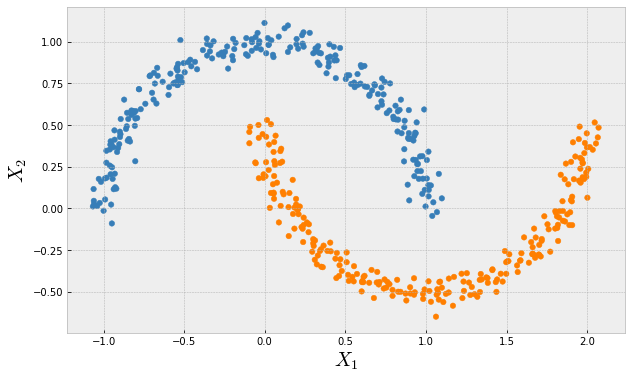

In [4]:
plot_data(X, Y)

## Linear Model <a name="linear_mod"></a>

### Definition <a name="linear_def"></a>

Lets first attempt to solve this with a traditional linear classifier: Multinomial Logistic or Softmax Regression. This is a Generalised Linear Model, as it composes a standard linear model [$\tilde{\hspace{0pt}Y}=\boldsymbol{\beta^T X}$] with a softmax function: $\sigma_s(\boldsymbol{z})_i=\frac{e^{z_i}}{\sum_k e^{z_k}} \in (0,1)$, where each element of $\boldsymbol{z}$ corresponds to a different class. Softmax functions have a deliberate probabilistic interpretation, giving the full model:

$$\tilde{\hspace{0pt}Y}_i \equiv \text{P}(Y=y_i|\boldsymbol{X};\boldsymbol{\beta}) \equiv \sigma_s(\boldsymbol{I})_i \equiv \sigma_s(\boldsymbol{\beta^{T} X})_i \equiv \frac{e^{\hspace{1pt}\boldsymbol{\beta_i^{T} X}}}{\sum_k e^{\hspace{1pt}\boldsymbol{\beta_k^{T} X}}} $$

If there are $K$ classes and $F$ features, then $\boldsymbol{\beta} = [\boldsymbol{\beta}_1, ..., \boldsymbol{\beta}_K] \in \mathbb{R}^{F\times K}$ with each column $\boldsymbol{\beta}_i \in \mathbb{R}^{F\times1}$ corresponding to class $y_i$. Finally, these probabilities are turned into a classification, for a given input $\boldsymbol{X}$, by simply selecting the class with the highest predicted probability.

Note that we could have used a logistic function for our simple binary example, but casting it as a multi-class problem makes our results more generalisable.

### Training <a name="linear_train"></a>

Now we must define a cost function. For a given input, $\boldsymbol{X}$, our model produces a vector output representing the predicted probability of being in each class, perhaps $\tilde{\hspace{0pt}Y} = [0.8, 0.2]$ in our simple binary example. We can one-hot encode our training outputs into a similar probabilistic format. For example, perhaps this sample corresponded to Class 0 and hence $Y = [1,0]$. Assuming the model is correct, the *likelihood* of this outcome is $0.8^1\times 0.2^0$.

In general for many classes, the likelihood of a single outcome under a proposed model is $\prod_k \tilde{\hspace{0pt}Y}_k^{Y_k}$. Thus the likelihood function, for a given parameter set $\boldsymbol{\beta}$, can be computed using the whole training set, assuming all $n$ observations are independent:

$\mathcal{L}(\boldsymbol{\beta}) = \prod_{j=1}^n \big(\prod_k \tilde{\hspace{0pt}Y}_k^{Y_k} \big)_j$

$\implies \log{\mathcal{L}(\boldsymbol{\beta})} = \sum_{j=1}^n \big( \sum_k Y_k\log{\tilde{\hspace{0pt}Y}_k}  \big)_j$

Maximising this likelihood is one way to estimate the parameters $\boldsymbol{\beta}$.

A different approach attempts to minimise the cross-entropy. Cross-entropy, $\mathcal{H}$, is a measure of dissimilarity between a true distribution, $Y$, and its approximating distribution, $\tilde{\hspace{0pt}Y}$. For discrete distributions it can be computed as:

$\mathcal{H}(Y,\tilde{\hspace{0pt}Y}) = -\text{E}_Y[\log(\tilde{\hspace{0pt}Y})] = -\sum_k \text{P}(Y=y_k)\log[\text{P}(\tilde{\hspace{0pt}Y}=y_k)] \approx \frac{1}{N}\sum_{j=1}^N \big( -\sum_k Y_k\log{\tilde{\hspace{0pt}Y}_k}  \big)_j \equiv \frac{1}{N}\sum_{j=1}^N h(Y,\tilde{\hspace{0pt}Y})$

where the penultimate step shows how we would approximate this expectation from our $N$ training samples. The final step defines the cross-entropy for a single sample, $h$. It should now be clear that, for this model, minimising the cross-entropy is equivalent to maximising the log-likelihood.

Going forward we will attempt to minimise cross-entropy, $\mathcal{H}(\boldsymbol{\beta})$, to calibrate our model. We will use a common optimisation scheme known as *gradient descent*. This essentially follows the algorithm:

- Set random initial value: $\boldsymbol{\beta}_i^{\hspace{1pt}(0)}$
- `for max_iter`:  
$\qquad\boldsymbol{\beta}_{i}^{\hspace{1pt}(m+1)} = \boldsymbol{\beta}_i^{\hspace{1pt}(m)} - \gamma \nabla_{\boldsymbol{\beta}_i}\mathcal{H}$

where `max_iter` is the maximum number of iterations, $\gamma$ is the learning rate and $\boldsymbol{\beta}_i^{\hspace{1pt}(m)}$ is the $m^{\text{th}}$ iteration of $\boldsymbol{\beta}_i$. We can compute the sensitivity of the cross-entropy to the $\boldsymbol{\beta}_i$ of each class with careful use of vector calculus and the chain rule:

$\nabla_{\boldsymbol{\beta}_i}h(\boldsymbol{\beta}) = \frac{\partial}{\partial\beta_{im}} \big( -\sum_k Y_k \log{\tilde{\hspace{0pt}Y}_k}\big) = -\sum_k Y_k \frac{\partial}{\partial\tilde{\hspace{0pt}Y}_k}\big( \log{\tilde{\hspace{0pt}Y}_k}\big) \frac{\partial\tilde{\hspace{0pt}Y}_k}{\partial\beta_{im}} = -\sum_k \frac{Y_k}{\tilde{\hspace{0pt}Y}_k} \frac{\partial\sigma_s(\boldsymbol{I})_k}{\partial\beta_{im}} = -\sum_k \frac{Y_k}{\tilde{\hspace{0pt}Y}_k} \frac{\partial I_p}{\partial\beta_{im}} \frac{\partial\sigma_s(\boldsymbol{I})_k}{\partial I_p} = -\sum_k \frac{Y_k \delta_{ip} X_m}{\tilde{\hspace{0pt}Y}_k} \frac{\partial\sigma_s(\boldsymbol{I})_k}{\partial I_p}$

$\frac{\partial\sigma_s(\boldsymbol{I})_k}{\partial I_p} = \frac{\partial}{\partial I_p}\big( \frac{e^{I_k}}{\sum_q e^{I_q}}\big) = \frac{\delta_{pk}e^{I_k}}{\sum_q e^{I_q}} - \frac{e^{I_p}e^{I_k}}{(\sum_q e^{I_q})^2} = \tilde{\hspace{0pt}Y}_k(\delta_{pk} - \tilde{\hspace{0pt}Y}_p)$

Therefore:

$\nabla_{\boldsymbol{\beta}_i}h(\boldsymbol{\beta}) = X_m \sum_k Y_k(\tilde{\hspace{0pt}Y}_i - \delta_{ik}) = X_m(\tilde{\hspace{0pt}Y}_i \sum_k Y_k - Y_i) = X_m(\tilde{\hspace{0pt}Y}_i - Y_i)$

Where the last equality uses the fact that $Y$ is one-hot encoded. Bringing these results together:

$\nabla_{\boldsymbol{\beta}_i}\mathcal{H}(\boldsymbol{\beta}) = \frac{1}{N}\sum_{j=1}^N \nabla_{\boldsymbol{\beta}_i}h(\boldsymbol{\beta}) = \frac{1}{N}\sum_{j=1}^N \big( \boldsymbol{X}(\tilde{\hspace{0pt}Y}_i - Y_i) \big)_j \in \mathbb{R}^{F\times K}$

### Implementation <a name="linear_imp"></a>

To gain some intuition for how the trained model is making classifications we can plot the separating hyperplane between the two classes. In our binary case the limiting condition is simply when the model predicts the same probability for each class:

$$\boldsymbol{\beta}_1^T\boldsymbol{X} = \boldsymbol{\beta}_2^T\boldsymbol{X} \implies (\boldsymbol{\beta}_1^T - \boldsymbol{\beta}_2^T)\boldsymbol{X} = 0$$

Note that this plane is constrained to pass through the origin as we didn't add a constant bias term. By viewing the output of this model as a separating boundary, we're beginning to take a Support-Vector Machine (SVM) approach. This is a binary classification method that begins by modelling the optimal hyperplane ($\boldsymbol{W}^T\boldsymbol{X} - b =0$) and then constructs a loss function that penalises points on the wrong side of the boundary according to their distance from it.

In [66]:
class ClassifierBase(ABC):

    def __init__(self, name: str, learning_rate: float, max_iter: int):
        self.name = name
        self._learning_rate = learning_rate
        self._max_iter = max_iter

    # X: (num_trials, num_features)
    # Y = the target class for each trial: (num_trials, 1)
    @abstractmethod
    def train(self, X: np.ndarray, Y: np.ndarray):
        pass

    # X: (num_trials, num_features)
    # Returns predicted probabilities: (num_trials, num_classes)
    @abstractmethod
    def _compute_probs(self, X: np.ndarray):
        pass

    # Return all fitted parameters associated to layer
    @abstractmethod
    def get_weights(self, layer: int):
        pass
    
    # X: (num_trials, num_features)
    # Feeds X forward through all of the hidden layers.
    # Returns the output of the final hidden layer projected into X space: (num_trials, num_features)
    @abstractmethod
    def get_hidden_projection(self, X):
        pass

    # x1: a one-dimensional vector of values representing the first node in the final hidden layer
    # Returns corresponding second node values for points on the separating boundary: len(x)
    # Note, this only makes sense for a binary (num_classes=2), 2d (num_features=2) case
    @abstractmethod
    def binary_boundary(self, x1: np.array):
        pass

    # X: (num_trials, num_features)
    # Returns predicted classes: (num_trials, 1)
    def predict(self, X: np.ndarray):
        probs = self._compute_probs(X)
        return self._classify_probs(probs)

    # probs: (num_trials, num_classes)
    # Y = the target class for each trial: (num_trials, 1)
    # Returns our current accuracy score: scalar
    def _compute_accuracy(self, probs, Y):
        predictions = self._classify_probs(probs)
        return sum(predictions == Y)/(float(len(Y)))

    # probs: (num_trials, num_classes)
    # Returns predicted classes: (num_trials, 1)
    def _classify_probs(self, probs: np.ndarray):
        return np.argmax(probs, axis=1)

    # Y_one_hot = the true training targets one-hot encoded: (num_trials, num_classes)
    # Y_pred_probs = predicted probabilities: (num_trials, num_classes)
    # Returns cross entropy: scalar
    @staticmethod
    def _compute_cross_entropy(Y_one_hot: np.ndarray, Y_pred_probs: np.ndarray, num_trials: int):
        # element-wise multiplication
        cross_entropy_matrix = np.multiply(Y_one_hot, np.log(Y_pred_probs))
        return (-1 / num_trials) * np.sum(cross_entropy_matrix)

    # Y = the target class for each trial: (num_trials, 1)
    # Returns a set of probabilities for each trial: (num_trials, num_classes)
    @staticmethod
    def _convert_to_one_hot(Y: np.ndarray, num_classes: int):
        one_hot = np.zeros((len(Y), num_classes))

        for i in range(len(Y)):
            one_hot[i][Y[i]] = 1

        return one_hot

    # applies element-wise: X.shape
    @staticmethod
    def _relu(X):
        return np.maximum(0, X)

    # X = (num_trials, num_classes)
    # Returns rows normalised to 1 so they represent probabilities: X.shape
    @staticmethod
    def _softmax(X):
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

In [6]:
class SoftMaxClassifier(ClassifierBase):

    def __init__(self, name: str, max_iter: int, learning_rate=0.1):
        super().__init__(name, learning_rate, max_iter)

    # Computes the probability of each class for many trials X
    # Returns a matrix with shape (len(X), num_classes)
    def _compute_probs(self, X):
        return self._softmax(X @ self._betas)
    
    def get_weights(self, layer: int):
        return self._betas
    
    def get_hidden_projection(self, X):
        # Simply return X as there are no hidden layers in this model
        return X
    
    def binary_boundary(self, x1):
        diff_betas = self._betas[:,0] - self._betas[:,1]
        return -1 * (diff_betas[0] / diff_betas[1]) * x1

    def train(self, X, Y):

        num_trials = len(X)
        num_classes = len(set(Y))
        num_features = X.shape[1]
        Y_one_hot = self._convert_to_one_hot(Y, num_classes)

        # each column corresponds to a beta vector for a particular class
        self._betas = np.random.rand(num_features, num_classes)

        for i in range(self._max_iter):

            probs = self._compute_probs(X)

            # could add some regularisation here?
            loss = self._compute_cross_entropy(Y_one_hot=Y_one_hot, Y_pred_probs=probs,
                                                num_trials=num_trials)

            accuracy = self._compute_accuracy(probs=probs, Y=Y)

            if i % 50 == 0:
                print("iteration {:.0f}: loss {:.5f}, accuracy {:.1f}%".format(i, loss, 100*accuracy))

            dhdb2 = X.T @ (probs - Y_one_hot) / num_trials
            self._betas -= self._learning_rate * dhdb2

In [7]:
classifier = SoftMaxClassifier(name="Custom_SoftMax_Imp", max_iter=1000)
classifier.train(X, Y)

iteration 0: loss 0.64441, accuracy 74.8%
iteration 50: loss 0.38446, accuracy 82.6%
iteration 100: loss 0.32891, accuracy 84.2%
iteration 150: loss 0.30452, accuracy 85.4%
iteration 200: loss 0.29135, accuracy 86.4%
iteration 250: loss 0.28341, accuracy 86.6%
iteration 300: loss 0.27827, accuracy 86.6%
iteration 350: loss 0.27478, accuracy 86.6%
iteration 400: loss 0.27231, accuracy 86.6%
iteration 450: loss 0.27053, accuracy 86.6%
iteration 500: loss 0.26921, accuracy 86.6%
iteration 550: loss 0.26821, accuracy 86.6%
iteration 600: loss 0.26745, accuracy 86.8%
iteration 650: loss 0.26686, accuracy 86.8%
iteration 700: loss 0.26639, accuracy 87.0%
iteration 750: loss 0.26603, accuracy 87.2%
iteration 800: loss 0.26574, accuracy 87.2%
iteration 850: loss 0.26551, accuracy 87.4%
iteration 900: loss 0.26533, accuracy 87.4%
iteration 950: loss 0.26518, accuracy 87.6%


In [8]:
class SoftMaxClassifierTF(ClassifierBase):

    def __init__(self, name: str, max_iter: int, learning_rate=0.1):
        super().__init__(name, learning_rate, max_iter)
        
    def _compute_probs(self, X: np.ndarray):
        return self.model.predict(X)

    def get_weights(self, layer: int):
        return self.model.layers[layer].get_weights()
    
    def get_hidden_projection(self, X):
        # Simply return X as there are no hidden layers in this model
        return X
    
    def binary_boundary(self, x1: np.array):
        betas = self.get_weights(1)[0]
        diff_betas = betas[:, 0] - betas[:, 1]
        return -1 * (diff_betas[0] / diff_betas[1]) * x1

    def train(self, X, Y):

        num_trials = len(X)
        num_classes = len(set(Y))
        num_features = X.shape[1]
        Y_one_hot = tf.one_hot(Y, depth=num_classes, dtype=tf.int32)

        input_layer = Input(shape=(num_features,))
        output_layer = Dense(num_classes, activation=tf.nn.softmax,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0),
                             use_bias=False)

        self.model = Model(inputs=input_layer, outputs=output_layer(input_layer))

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.SGD(learning_rate=self._learning_rate),
                      metrics=[tf.keras.metrics.CategoricalAccuracy()])

        history = self.model.fit(X, Y_one_hot, batch_size=num_trials, shuffle=False, verbose=0, epochs=self._max_iter)
        final_loss = history.history["loss"][-1]
        final_accuracy = history.history["categorical_accuracy"][-1]
        print("iteration {:.0f}: loss {:.5f}, accuracy {:.1f}%".format(self._max_iter-1, final_loss, 100*final_accuracy))
        

In [9]:
classifierTF = SoftMaxClassifierTF(name="TensorFlow_SoftMax_Imp", max_iter=1000)
classifierTF.train(X, Y)

iteration 999: loss 0.26506, accuracy 87.6%


In [10]:
classifier.get_weights(1)

array([[-0.09292156,  1.35692443],
       [ 2.87677844, -1.72913189]])

In [11]:
classifierTF.get_weights(1)

[array([[-0.26635662,  1.1833829 ],
        [ 3.0879943 , -1.5171418 ]], dtype=float32)]

My custom implementation, `SoftMaxClassifier`, reaches an accuracy of 87.6% and minimises the cross-entropy to 0.2652. Another implementation using an open-source TensorFlow graph, `SoftMaxClassifierTF`, achieves the same accuracy with a slightly lower loss of 0.2651. They also appear to have each settled on similar optimal parameters $\boldsymbol{\beta} \in \mathbb{R}^{2\times 2}$.

I attempted to make the open-source classifier as functionally close to the custom implementation as possible: they share the same learning rate, same number of iterations, same Gradient Descent optimiser batching the entire training data for each iteration and the same random distribution to sample for initial values.

Below a decision surface is plotted for each implementation. They are almost indistinguishable. Unsurprisingly, neither of these linear classifiers are able to differentiate the linearly non-seperable classes.

In [50]:
def plot_decision_surface(X, Y, model, plot_boundary=True):
    
    # Get the upper and lower bounds of the two input dimensions
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    
    step = 0.01
    # Create the mesh over the input space
    x1s, x2s = np.meshgrid(np.arange(x1_min, x1_max, step),
                           np.arange(x2_min, x2_max, step))
    
    y_pred = model.predict(np.c_[x1s.ravel(), x2s.ravel()])
    projected_hidden_Z = model.get_hidden_projection(X)
    z1_boundary = np.array([projected_hidden_Z[:,0].min(), projected_hidden_Z[:,0].max()])
    z2_boundary = model.binary_boundary(z1_boundary)
    
    # Plot the inputs and decision boundary on the input space
    figsize = (10, 12) if plot_boundary else (10, 6)
    layout = (2, 1) if plot_boundary else (1, 1)
    
    fig, ax = plt.subplots(figsize=figsize)

    surface_ax = plt.subplot2grid(layout, (0, 0))
    surface_ax.scatter(x1s.ravel(), x2s.ravel(), s=10, color=colors[y_pred.ravel()])
    surface_ax.scatter(X[:, 0], X[:, 1], s=30, color=colors[Y], edgecolors='black')
    surface_ax.set_xlim(x1_min, x1_max)
    surface_ax.set_ylim(x2_min, x2_max)
    surface_ax.set_xlabel(r'$X_1$', size=15)
    surface_ax.set_ylabel(r'$X_2$', size=15)
    surface_ax.set_title("Decision surface for {:}".format(model.name), size=15)
    
    if not plot_boundary:
        plt.show()
        return
    
    boundary_ax = plt.subplot2grid(layout, (1, 0))
    boundary_ax.scatter(projected_hidden_Z[:, 0], projected_hidden_Z[:, 1], s=30, color=colors[Y])
    boundary_ax.plot(z1_boundary, z2_boundary, color='k', linestyle='-', linewidth=2)
    boundary_ax.set_xlabel(r'$Z_1^{(L-1)}$', size=15)
    boundary_ax.set_ylabel(r'$Z_2^{(L-1)}$', size=15)
    boundary_ax.set_title("Decision boundary in final hidden layer projected into 2D for {:}".format(model.name), size=15)
    
    plt.show()

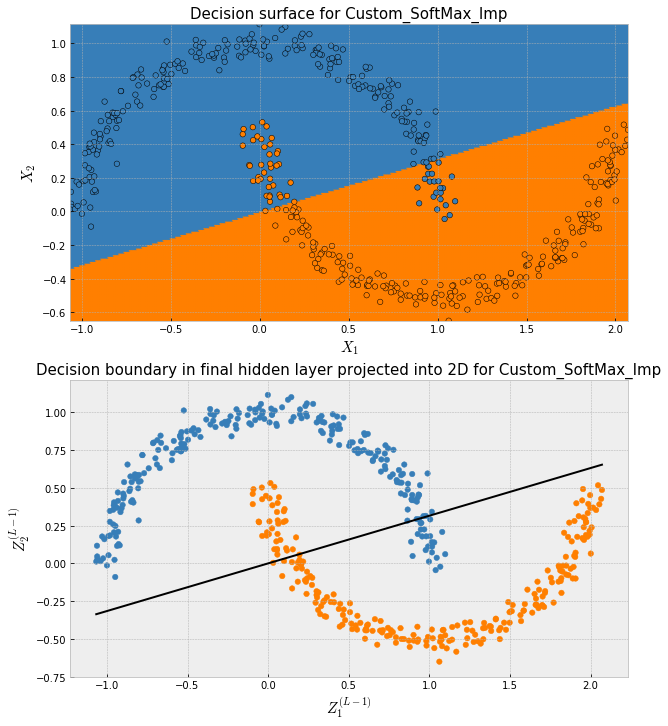

In [52]:
plot_decision_surface(X, Y, classifier)

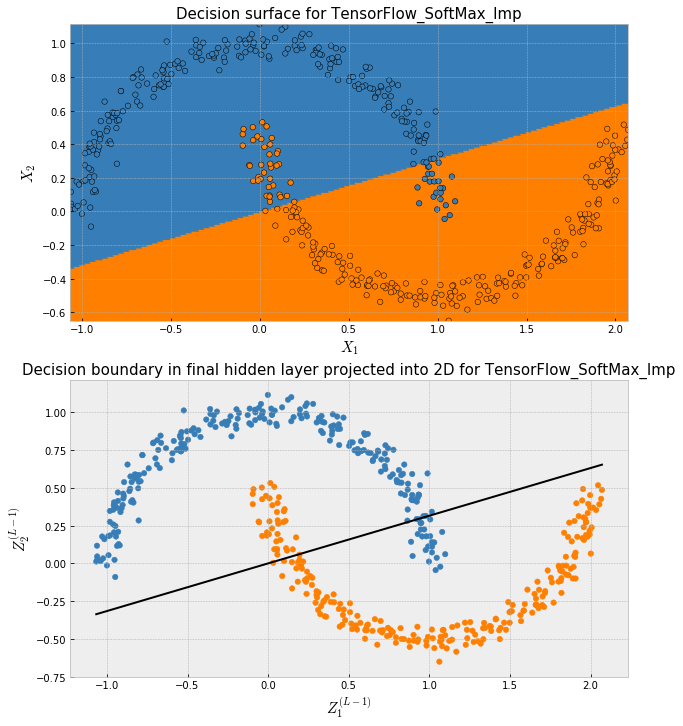

In [53]:
plot_decision_surface(X, Y, classifierTF)

## Neural Network Model <a name="neural_net"></a>

### Definition <a name="net_def"></a>

A feedforward neural network that is composed of $L$ layers has the form:

$$\tilde{\hspace{0pt}Y}(\boldsymbol{X}) = F_{W,\hspace{1pt}b}(\boldsymbol{X}) = \big(f_{\boldsymbol{W}^{(L)},\hspace{1pt}\boldsymbol{b}^{(L)}}^{(L)} \circ ... \circ f_{\boldsymbol{W}^{(1)},\hspace{1pt}\boldsymbol{b}^{(1)}}^{(1)}\big)(\boldsymbol{X})$$

where:
- $f_{\boldsymbol{W}^{(l)},\hspace{1pt}\boldsymbol{b}^{(l)}}^{(l)}(\boldsymbol{X}) \equiv \sigma^{(l)}(\boldsymbol{I}^{(l)}) \equiv \sigma^{(l)}(\boldsymbol{W}^{(l)^\boldsymbol{T}}\boldsymbol{X} + \boldsymbol{b}^{(l)})$ corresponds to layer $l$
- $\sigma^{(l)}(x)$ is a one-dimensional and continuous activation function that is applied element-wise
- $W = (\boldsymbol{W}^{(1)}, ..., \boldsymbol{W}^{(L)})$ and $b = (\boldsymbol{b}^{(1)}, ..., \boldsymbol{b}^{(L)})$ are weight matrices and bias vectors respectively. Each column in $\boldsymbol{W}^{(l)}$ corresponds to a single node in layer $l$ and determines how to weight the outputs from the previous layer.

<img src="neural_net.svg" alt="Drawing" style="width: 500px;"/>

There are inputs, $L-1$ hidden layers and an output layer as depicted above. Note that if all of the activation functions are linear then, regardless of how many hidden layers there are, a standard linear regression model is recovered:

$$\tilde{\hspace{0pt}Y}(\boldsymbol{X}) = F_{W,b}(\boldsymbol{X}) = \boldsymbol{\bar{W}^TX} + \boldsymbol{\bar{b}}$$

Remarkably, it can be shown that feedforward neural networks with a single hidden layer and non-linear activation functions are universal approximators to non-linear functions.

For our problem, we will have $F$ nodes in the input layer (one for each feature), one hidden layer with $H$ nodes and a final output layer with $K$ nodes all of which use a softmax activation, $\sigma_s$. This is to output a predicted probability for each class. Every layer will be fully connected to the next layer, hence the network will take the form:

- input layer: $Z^{(0)} = \boldsymbol{X} \in \mathbb{R}^{F\times1}$
- hidden layer: $Z^{(1)} = \sigma^{(1)}(\boldsymbol{I}^{(1)}) = \sigma^{(1)}(\boldsymbol{W}^{(1)^\boldsymbol{T}}\boldsymbol{X} + \boldsymbol{b}^{(1)})$ where $\boldsymbol{W}^{(1)} \in \mathbb{R}^{F\times H}$, $\boldsymbol{b}^{(1)} \in \mathbb{R}^{H\times1}$
- output layer: $\tilde{\hspace{0pt}Y}(\boldsymbol{X}) = Z^{(2)} = \sigma^{(2)}(\boldsymbol{I}^{(2)}) =  \sigma_s(\boldsymbol{W}^{(2)^\boldsymbol{T}}\boldsymbol{Z}^{(1)} + \boldsymbol{b}^{(2)}) \in [0,1]^K$ where $\boldsymbol{W}^{(2)} \in \mathbb{R}^{H\times K}$, $\boldsymbol{b}^{(2)} \in \mathbb{R}^{K\times 1}$

Note that if we didn't include the hidden layer, we would simply be left with the final output layer (softmax composed with a linear function) which reduces to our previous model.

### Training <a name="net_train"></a>

Just as before, we will calibrate our model by attempting to minimise the cross-entropy. We will approximate this from our $N$ training samples using:

$\mathcal{H}(W, b) = \frac{1}{N}\sum_{j=1}^N h(W, b) = \frac{1}{N}\sum_{j=1}^N \big( -\sum_k Y_k\log{\tilde{\hspace{0pt}Y}_k}  \big)_j = \frac{1}{N}\sum_{j=1}^N \big( -\sum_k Y_k\log{Z_k^{(L)}}  \big)_j$

In our previous model there were $F \times K$ parameters to estimate: 4 in our case. This time there are $H(F+1) + K(H+1)$: $5H+2$ in our case.

Using gradient descent, update rules for weights and biases are:

$\Delta\boldsymbol{W}^{(l)} = - \gamma \nabla_{\boldsymbol{W}^{(l)}}\mathcal{H}, \quad \Delta\boldsymbol{b}^{(l)} = - \gamma \nabla_{\boldsymbol{b}^{(l)}}\mathcal{H}$

We've already done most of the work to determine the sensitivity of the cross-entropy to weights and biases in the final layer:

$\nabla_{\boldsymbol{W}^{(L)}}h(W, b) = \frac{\partial}{\partial W_{im}} \big( -\sum_k Y_k \log{Z_k^{(L)}}\big) = \sum_k Y_k \frac{\partial I_p^{(L)}}{\partial W_{im}} (Z_p^{(L)} - \delta_{pk}) = \sum_k Y_k \delta_{ip}Z_m^{(L-1)} (Z_p^{(L)} - \delta_{pk}) = Z_m^{(L-1)}(Z_i^{(L)} - Y_i)$

$\nabla_{\boldsymbol{b}^{(L)}}h(W, b) = \sum_k Y_k \frac{\partial I_p^{(L)}}{\partial b_i} (Z_p^{(L)} - \delta_{pk}) = \sum_k Y_k \delta_{ip} (Z_p^{(L)} - \delta_{pk}) = Z_i^{(L)} - Y_i$

It follows that:

$\nabla_{\boldsymbol{W}^{(L)}}h = Z^{(L-1)} \otimes \nabla_{\boldsymbol{b}^{(L)}}h \in \mathbb{R}^{H\times K},$

where $\otimes$ denotes the outer product of the two vectors. Unlike in our previous model, the loss now needs to be propagated back to the previous layer. This is called *backpropagation*, which itself is a special case of *reverse automatic differentiation*. The recursion pattern becomes clear pretty quickly, with the only unknown being the derivative of the activation function. Here we assume that the $L-1$ layer uses a Relu activation function ($\sigma(z)=\max(0, z)$). This provides the non-linearity we need and has a convenient derivative, the Heaviside function: $\mathbb{H}(z)$. In this case it can be shown that the sensitivities are:

$\nabla_{\boldsymbol{W}_{im}^{(L-1)}}h(W, b) = Z_m^{(L-2)}\mathbb{H}(I_i^{(L-1)})(Z_p^{(L)} - Y_p)W_{pi}^{(L)}$

$\nabla_{\boldsymbol{b}_{i}^{(L-1)}}h(W, b) = \mathbb{H}(I_i^{(L-1)})(Z_p^{(L)} - Y_p)W_{pi}^{(L)}$

Thus the following recursions can be deduced:

$\nabla_{\boldsymbol{b}^{(L-1)}}h =  \mathbb{H}(\boldsymbol{I}^{(L-1)})\odot(\boldsymbol{W}^{(L)}\nabla_{\boldsymbol{b}^{(L)}}h) \in \mathbb{R}^{H\times 1}$

$\nabla_{\boldsymbol{W}^{(L-1)}}h = Z^{(L-2)} \otimes \nabla_{\boldsymbol{b}^{(L-1)}}h \in \mathbb{R}^{F\times H},$

where $\odot$ denotes the Hadamard or element-wise product.

### Implementation <a name="net_imp"></a>

Visualising the decision boundary is a little trickier now we have a hidden layer. In the binary case the limiting condition is now:

$I_0^{(L)} = I_1^{(L)} \implies W_{0i}^{(L)^T}Z_{i}^{(L-1)} + b_0^{(L)} = W_{1i}^{(L)^T}Z_{i}^{(L-1)} + b_1^{(L)} \implies (W_{0i}^{(L)^T} - W_{1i}^{(L)^T})Z_{i}^{(L-1)} = b_1^{(L)} - b_0^{(L)}$

In general this hyperplane lives in $Z^{(L-1)}$: an $H$-dimensional space. To visualise it we will project it into 2D space by simply selecting its first two components.

In [25]:
class NeuralNetClassifier(ClassifierBase):

    def __init__(self, name: str, num_hidden_nodes: int, max_iter: int, learning_rate=0.1):
        super().__init__(name, learning_rate, max_iter)
        self._num_hidden_nodes = num_hidden_nodes

    def _compute_probs(self, X: np.ndarray):

        self._compute_hidden_layers(X)

        # Output Layer:
        # each row corresponds to a trial: (num_trials, num_classes)
        I2 = self.Z1 @ self.W2 + self.b2
        return self._softmax(I2)

    def get_weights(self, layer: int):
        return self.weights[layer]
    
    def _compute_hidden_layers(self, X: np.ndarray):

        # Hidden Layer:
        # each row corresponds to a trial: (num_trials, num_hidden_nodes)
        # I1 & Z1 are used later in the backpropagation
        self.I1 = X @ self.W1 + self.b1
        self.Z1 = self._relu(self.I1)
        
    def get_hidden_projection(self, X):
        self._compute_hidden_layers(X)
        return self.Z1[:, 0:X.shape[1]]

    def binary_boundary(self, x1: np.array):
        diff_b = self.b2[0][1] - self.b2[0][0]
        diff_W = self.W2[:,0] - self.W2[:,1]
        return (diff_b - diff_W[0] * x1) / diff_W[1]

    def train(self, X, Y):

        num_trials = len(X)
        num_classes = len(set(Y))
        num_features = X.shape[1]
        Y_one_hot = self._convert_to_one_hot(Y, num_classes)

        # each column corresponds to a node in the hidden layer
        self.W1 = np.random.rand(num_features, self._num_hidden_nodes)
        self.b1 = np.zeros((1, self._num_hidden_nodes))

        # each column corresponds to a node in the output layer: hence also a class
        self.W2 = np.random.rand(self._num_hidden_nodes, num_classes)
        self.b2 = np.zeros((1, num_classes))

        for i in range(self._max_iter):

            # Feedforward:

            probs = self._compute_probs(X)

            loss = self._compute_cross_entropy(Y_one_hot=Y_one_hot, Y_pred_probs=probs,
                                               num_trials=num_trials)

            accuracy = self._compute_accuracy(probs=probs, Y=Y)

            if i % 50 == 0:
                print("iteration {:.0f}: loss {:.5f}, accuracy {:.1f}%".format(i, loss, 100*accuracy))

            # Backpropagate loss:

            # Output Layer
            dhdb2 = probs - Y_one_hot
            # averaged across all trials
            dhdW2 = self.Z1.T @ dhdb2 / num_trials

            # Hidden Layer
            # element-wise multiplication
            dhdb1 = np.multiply(np.heaviside(self.I1, 0), dhdb2 @ self.W2.T)
            # averaged across all trials
            dhdW1 = X.T @ dhdb1 / num_trials

            # finally average over all trials for the biases:
            dhdb2 = np.sum(dhdb2, axis=0, keepdims=True) / num_trials
            dhdb1 = np.sum(dhdb1, axis=0, keepdims=True) / num_trials

            # Update parameters:

            # Output Layer
            self.W2 -= self._learning_rate * dhdW2
            self.b2 -= self._learning_rate * dhdb2

            # Hidden Layer
            self.W1 -= self._learning_rate * dhdW1
            self.b1 -= self._learning_rate * dhdb1

        weights1 = {"W": self.W1, "b": self.b1}
        weights2 = {"W": self.W2, "b": self.b2}

        self.weights = {1: weights1, 2: weights2}

In [16]:
nnClassifier5 = NeuralNetClassifier(name="Custom_Neural_Imp_5_Hidden", max_iter=2000, num_hidden_nodes=5)
nnClassifier5.train(X, Y)

iteration 0: loss 0.78073, accuracy 58.6%
iteration 50: loss 0.56058, accuracy 74.2%
iteration 100: loss 0.35839, accuracy 86.4%
iteration 150: loss 0.28088, accuracy 88.0%
iteration 200: loss 0.24968, accuracy 88.6%
iteration 250: loss 0.23407, accuracy 89.2%
iteration 300: loss 0.22699, accuracy 89.0%
iteration 350: loss 0.22348, accuracy 89.2%
iteration 400: loss 0.22115, accuracy 89.4%
iteration 450: loss 0.21939, accuracy 89.2%
iteration 500: loss 0.21794, accuracy 89.6%
iteration 550: loss 0.21673, accuracy 90.0%
iteration 600: loss 0.21568, accuracy 90.0%
iteration 650: loss 0.21476, accuracy 90.0%
iteration 700: loss 0.21395, accuracy 89.8%
iteration 750: loss 0.21324, accuracy 89.8%
iteration 800: loss 0.21260, accuracy 89.8%
iteration 850: loss 0.21202, accuracy 89.8%
iteration 900: loss 0.21150, accuracy 89.8%
iteration 950: loss 0.21103, accuracy 89.6%
iteration 1000: loss 0.21060, accuracy 89.6%
iteration 1050: loss 0.21022, accuracy 89.6%
iteration 1100: loss 0.20987, acc

In [17]:
class NeuralNetClassifierTF(ClassifierBase):

    def __init__(self, name: str, num_hidden_nodes: int, max_iter: int, learning_rate=0.1):
        super().__init__(name, learning_rate, max_iter)
        self._num_hidden_nodes = num_hidden_nodes
        
    def _compute_probs(self, X: np.ndarray):
        return self.model.predict(X)

    def get_weights(self, layer: int):
        weights = self.model.layers[layer].get_weights()
        return {"W": weights[0], "b": weights[1]}
    
    def get_hidden_projection(self, X):
        Z1 = self.model.layers[1](X)
        return Z1.numpy()[:, 0:X.shape[1]]

    def binary_boundary(self, x1: np.array):
        W2 = self.get_weights(2)["W"]
        b2 = self.get_weights(2)["b"]
        diff_b = b2[1] - b2[0]
        diff_W = W2[:, 0] - W2[:, 1]
        return (diff_b - diff_W[0] * x1) / diff_W[1]

    def train(self, X, Y):

        num_trials = len(X)
        num_classes = len(set(Y))
        num_features = X.shape[1]
        Y_one_hot = tf.one_hot(Y, depth=num_classes, dtype=tf.int32)

        input_layer = Input(shape=(num_features,))

        hidden_layer = Dense(self._num_hidden_nodes, activation=tf.nn.relu,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0)
                             )(input_layer)

        output_layer = Dense(num_classes, activation=tf.nn.softmax,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0)
                             )(hidden_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer)

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.SGD(learning_rate=self._learning_rate),
                      metrics=[tf.keras.metrics.CategoricalAccuracy()])

        history = self.model.fit(X, Y_one_hot, batch_size=num_trials, shuffle=False, verbose=0, epochs=self._max_iter)
        final_loss = history.history["loss"][-1]
        final_accuracy = history.history["categorical_accuracy"][-1]
        print("iteration {:.0f}: loss {:.5f}, accuracy {:.1f}%".format(self._max_iter-1, final_loss, 100*final_accuracy))

In [18]:
nnClassifierTF5 = NeuralNetClassifierTF(name="TensorFlow_Neural_Imp_5_Hidden", max_iter=2000, num_hidden_nodes=5)
nnClassifierTF5.train(X, Y)

iteration 1999: loss 0.20680, accuracy 89.4%


My custom implementation, `NeuralNetClassifier`, reaches an accuracy of 89.4% and minimises the cross-entropy to 0.2067 when using 5 nodes in the hidden layer. The open-source implementation, `NeuralNetClassifierTF`, also achieves 89.4% with a slightly higher loss of 0.2068. These are both only slightly better than the 87.6% we achieved with the linear classifier. With 5 nodes in the hidden layer, there are 27 parameters to fit.

However, viewing the decision surfaces below we see that these models are doing something fundamentally different. In $\boldsymbol{X}$ feature space the decision boundary is now non-linear. The second plots show a 2D projection of the original data once it's passed through the hidden layer; that is, the output of the first two hidden nodes: $[Z_1^{(1)}, Z_2^{(1)}]$. The non-linear Relu activation function used by this hidden layer transforms the space in a non-linear way in an attempt to separate the two classes. In the higher-dimensional $\boldsymbol{Z}^{(1)}$ space the separating boundary is a linear hyperplane, which has also been projected in the second plots.

Whilst the decision surface in $\boldsymbol{X}$ space looks very similar for the two models, their solutions in projected $\boldsymbol{Z}^{(1)}$ space look very different. This is unsurprising as the two models begin with different random initial parameters and so each gradient descent will follow a different path. They end up arriving at very similar optimal loss values, but the solution in parameter space is almost certainly not unique. Finally, even if the two implementations did somehow settle on exactly the same optimal parameters, they could easily be simple re-orderings of one another. That is, the nodes in the hidden layer might be in a different order. Thus by plotting the first two components in $\boldsymbol{Z}^{(1)}$ space the solutions might look different even if they are topologically identical.

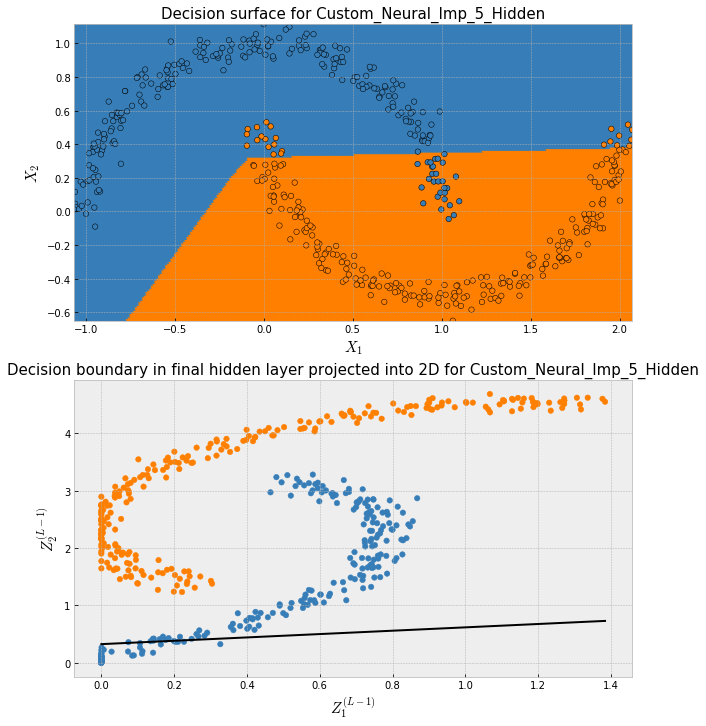

In [54]:
plot_decision_surface(X, Y, nnClassifier5)

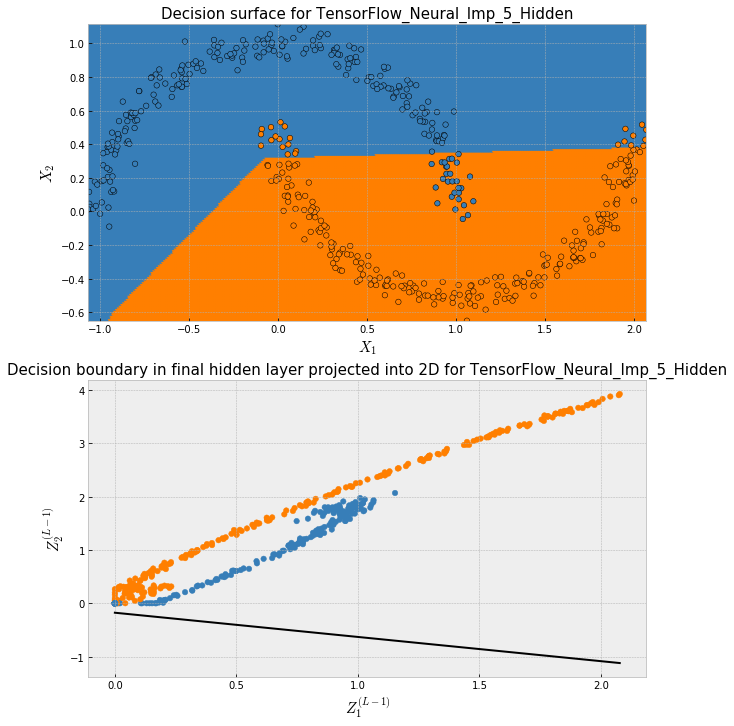

In [55]:
plot_decision_surface(X, Y, nnClassifierTF5)

In [30]:
nnClassifier25 = NeuralNetClassifier(name="Custom_Neural_Imp_25_Hidden", max_iter=2500, num_hidden_nodes=25)
nnClassifier25.train(X, Y)

iteration 0: loss 0.65626, accuracy 66.0%
iteration 50: loss 0.29612, accuracy 88.0%
iteration 100: loss 0.25902, accuracy 88.4%
iteration 150: loss 0.24202, accuracy 89.0%
iteration 200: loss 0.23245, accuracy 89.0%
iteration 250: loss 0.22641, accuracy 89.4%
iteration 300: loss 0.22245, accuracy 89.6%
iteration 350: loss 0.21976, accuracy 90.0%
iteration 400: loss 0.21780, accuracy 90.0%
iteration 450: loss 0.21628, accuracy 90.0%
iteration 500: loss 0.21499, accuracy 89.8%
iteration 550: loss 0.21387, accuracy 89.8%
iteration 600: loss 0.21288, accuracy 89.8%
iteration 650: loss 0.21199, accuracy 89.8%
iteration 700: loss 0.21113, accuracy 89.8%
iteration 750: loss 0.21017, accuracy 89.8%
iteration 800: loss 0.20888, accuracy 89.8%
iteration 850: loss 0.20724, accuracy 89.8%
iteration 900: loss 0.20527, accuracy 89.8%
iteration 950: loss 0.20285, accuracy 90.0%
iteration 1000: loss 0.19984, accuracy 90.2%
iteration 1050: loss 0.19608, accuracy 90.2%
iteration 1100: loss 0.19139, acc

In [31]:
nnClassifierTF25 = NeuralNetClassifierTF(name="TensorFlow_Neural_Imp_25_Hidden", max_iter=2500, num_hidden_nodes=25)
nnClassifierTF25.train(X, Y)

iteration 2499: loss 0.02059, accuracy 100.0%


By increasing the size of the hidden layer to 25, we can achieve a perfect score. The custom and open-source implementations decrease the loss to 0.0342 and 0.0206 respectively. With 25 nodes in the hidden layer, there are 127 parameters to fit. This can be visualised in feature space, $\boldsymbol{X}$, and the higher dimensional space of the hidden layer, $\boldsymbol{Z}^{(1)}$, via a 2D projection in the plots below.

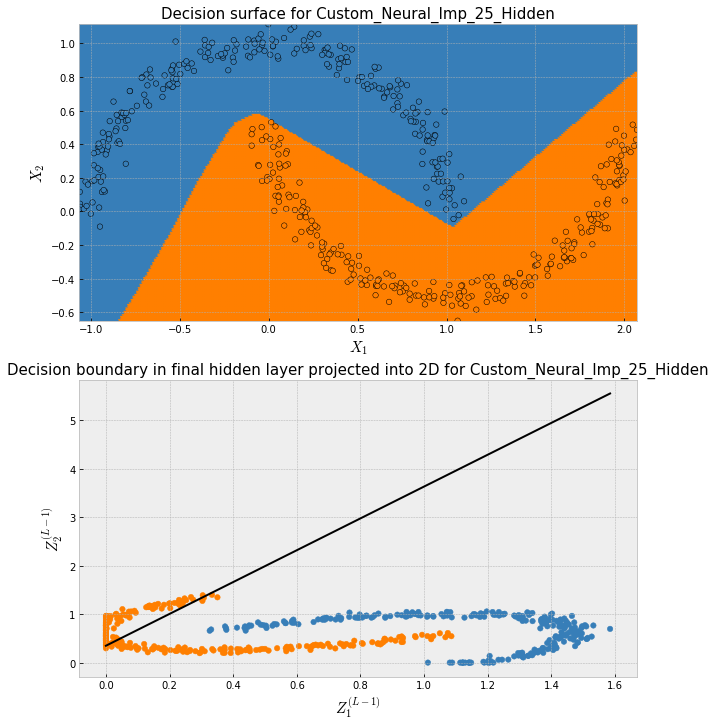

In [56]:
plot_decision_surface(X, Y, nnClassifier25)

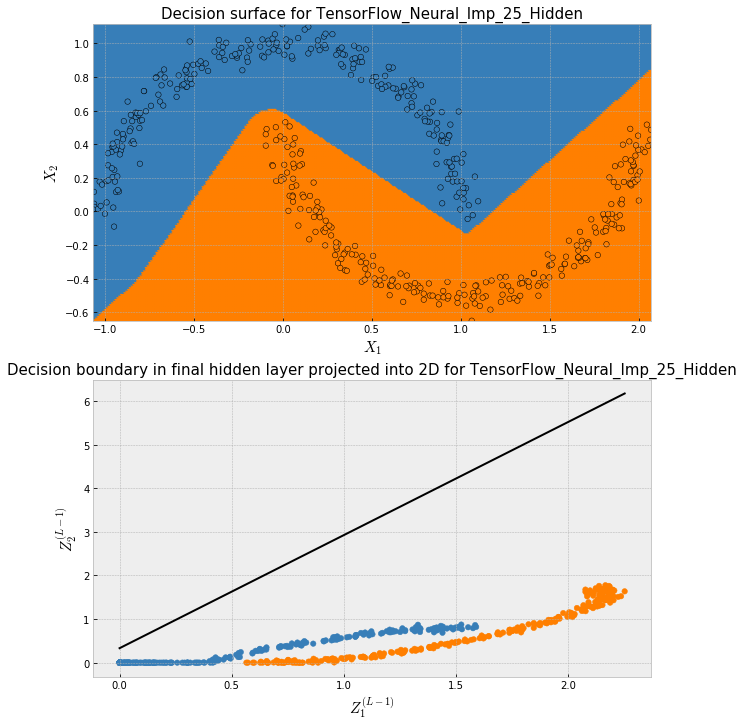

In [57]:
plot_decision_surface(X, Y, nnClassifierTF25)

## Why do Neural Networks work? <a name="why"></a>

Our first linear model had no hidden layers. It just had one layer, the output layer, using a softmax activitation in order to output probabilities. Equivalently you could represent this model using a hidden layer with a linear activation function, as a composition of linear functions is simply another linear function. This linear activation function can only rotate, stretch and translate the input feature space. In our example these transformations are not helpful in separating the two classes, no matter how many dimensions you project the problem into: equivalently, how many nodes you put in the hidden layer.

Our neural network model also had one hidden layer, but this time we used a non-linear Relu activation function. This allows the classifier to bend the input space. However, non-linear activations alone will not be sufficient. Consider the following example of two circular classes. If you stay in two-dimensions, no matter how much you bend the input space you will never be able to separate these two classes.

Another way of visualising this is by considering the boundary created in the input space, $\boldsymbol{X}$, by each node in the hidden layer. Since we used a Relu activation, the $i^{\text{th}}$ node in this layer outputs: $Z_i^{(1)} = \max(0, W_{ij}^{(1)^T}X_{j} + b_i^{(1)})$. This splits the input space into two regions, where the node is only activated (non-zero) when an observation is on the *best* side of the hyperplane: $W_{ij}^{(1)^T}X_{j} + b_i^{(1)} = 0$. When the node is activated, its value is equal to the observation's perpendicular distance to this hyperplane. Thus by only having two hidden nodes you're attempting to classify the data using only two hyperplanes, which can generate at most 4 regions. The plot below shows how this fails in our example.


In [34]:
X_circle, Y_circle = make_circles(n_samples=1000, factor=0.4, noise=0.05, random_state=seed)
nnClassifier2 = NeuralNetClassifier(name="Custom_Neural_Imp_2_Hidden", max_iter=2000, num_hidden_nodes=2)
nnClassifier2.train(X_circle, Y_circle)

iteration 0: loss 0.69173, accuracy 49.9%
iteration 50: loss 0.65789, accuracy 53.2%
iteration 100: loss 0.64112, accuracy 57.4%
iteration 150: loss 0.62738, accuracy 59.2%
iteration 200: loss 0.61590, accuracy 61.9%
iteration 250: loss 0.60666, accuracy 63.9%
iteration 300: loss 0.59958, accuracy 64.9%
iteration 350: loss 0.59391, accuracy 66.1%
iteration 400: loss 0.58964, accuracy 66.1%
iteration 450: loss 0.58632, accuracy 66.1%
iteration 500: loss 0.58372, accuracy 66.3%
iteration 550: loss 0.58166, accuracy 66.4%
iteration 600: loss 0.57998, accuracy 66.4%
iteration 650: loss 0.57848, accuracy 66.3%
iteration 700: loss 0.57699, accuracy 66.3%
iteration 750: loss 0.57546, accuracy 66.5%
iteration 800: loss 0.57392, accuracy 66.7%
iteration 850: loss 0.57193, accuracy 66.9%
iteration 900: loss 0.56859, accuracy 67.8%
iteration 950: loss 0.56251, accuracy 68.7%
iteration 1000: loss 0.55466, accuracy 70.3%
iteration 1050: loss 0.54483, accuracy 71.4%
iteration 1100: loss 0.53291, acc

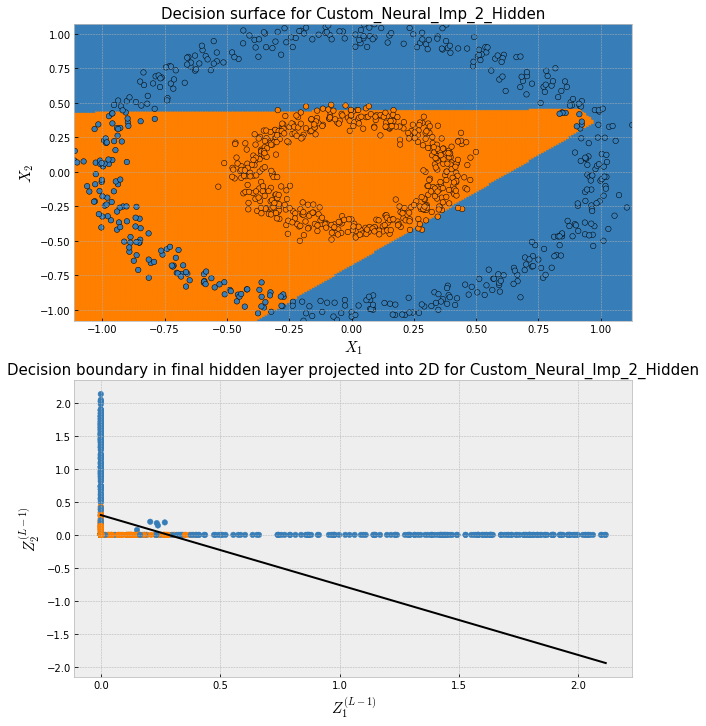

In [58]:
plot_decision_surface(X_circle, Y_circle, nnClassifier2)

However, by adding another node to the hidden layer we're allowing the model to project the data into three-dimensions. In this higher dimensional space a non-linear transformation is able to linearly separate the data. See image below for an example of this.

<img src="3d_transform.png" alt="Drawing" style="width: 500px;"/>

Equivalently, we're giving the model another hyperplane to help distinguish the classes in the input space, which can generate at most 7 regions. The plot below shows how this is achieved. Note, the corners of the triangle are cut because our model has two further nodes in the output layer.

In [36]:
nnClassifier3 = NeuralNetClassifier(name="Custom_Neural_Imp_3_Hidden", max_iter=2000, num_hidden_nodes=3)
nnClassifier3.train(X_circle, Y_circle)

iteration 0: loss 0.68352, accuracy 50.4%
iteration 50: loss 0.65316, accuracy 59.1%
iteration 100: loss 0.63011, accuracy 65.0%
iteration 150: loss 0.60735, accuracy 70.2%
iteration 200: loss 0.58306, accuracy 75.2%
iteration 250: loss 0.55686, accuracy 77.6%
iteration 300: loss 0.53023, accuracy 79.3%
iteration 350: loss 0.50411, accuracy 81.0%
iteration 400: loss 0.47992, accuracy 82.1%
iteration 450: loss 0.45934, accuracy 83.1%
iteration 500: loss 0.44338, accuracy 84.3%
iteration 550: loss 0.43091, accuracy 85.1%
iteration 600: loss 0.42099, accuracy 85.2%
iteration 650: loss 0.41223, accuracy 85.4%
iteration 700: loss 0.40447, accuracy 85.5%
iteration 750: loss 0.39700, accuracy 85.7%
iteration 800: loss 0.38948, accuracy 86.1%
iteration 850: loss 0.37952, accuracy 86.6%
iteration 900: loss 0.36687, accuracy 87.2%
iteration 950: loss 0.35251, accuracy 88.3%
iteration 1000: loss 0.33419, accuracy 89.8%
iteration 1050: loss 0.31450, accuracy 90.6%
iteration 1100: loss 0.29453, acc

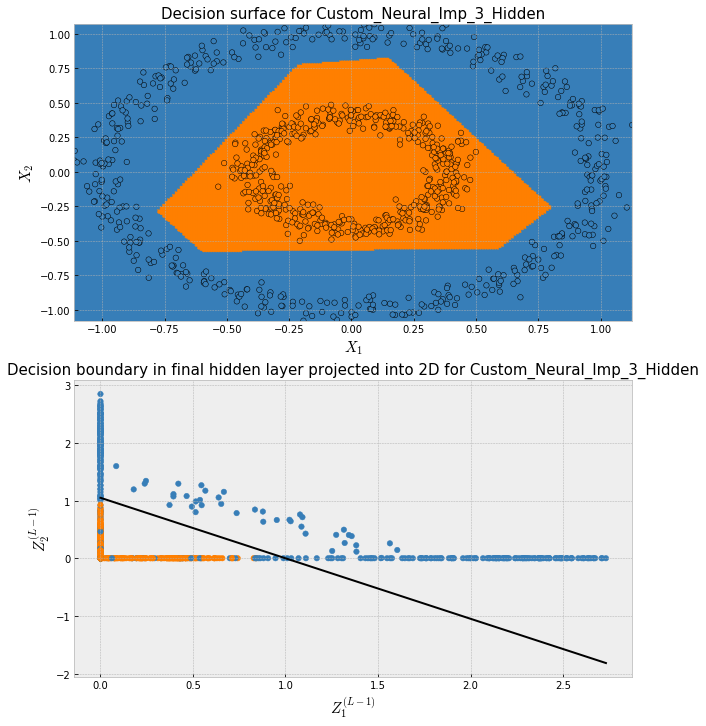

In [59]:
plot_decision_surface(X_circle, Y_circle, nnClassifier3)

Note that in our previous data set, even when we achieved a perfect score, our decision boundary in the final hidden layer didn't seem to linearly separate the data. This is caused by projecting the space down into just two-dimensions. A more illuminating plot in the transformed space can be achieved by adding another hidden layer with as many nodes as there are classes. The class `NeuralNetClassifierProjectTF` below implements this.

In our binary example we can view the full space of the final hidden layer in 2D without projecting. The plots below show how, in this new space, our hyperplane does indeed separate the data.

In [38]:
class NeuralNetClassifierProjectTF(ClassifierBase):

    def __init__(self, name: str, num_hidden_nodes: int, max_iter: int, learning_rate=0.1):
        super().__init__(name, learning_rate, max_iter)
        self._num_hidden_nodes = num_hidden_nodes
        
    def _compute_probs(self, X: np.ndarray):
        return self.model.predict(X)

    def get_weights(self, layer: int):
        weights = self.model.layers[layer].get_weights()
        return {"W": weights[0], "b": weights[1]}
    
    def get_hidden_projection(self, X):
        Z1 = self.model.layers[1](X)
        Z2 = self.model.layers[2](Z1)
        return Z2.numpy()[:, 0:X.shape[1]]

    def binary_boundary(self, x1: np.array):
        W2 = self.get_weights(3)["W"]
        b2 = self.get_weights(3)["b"]
        diff_b = b2[1] - b2[0]
        diff_W = W2[:, 0] - W2[:, 1]
        return (diff_b - diff_W[0] * x1) / diff_W[1]

    def train(self, X, Y):

        num_trials = len(X)
        num_classes = len(set(Y))
        num_features = X.shape[1]
        Y_one_hot = tf.one_hot(Y, depth=num_classes, dtype=tf.int32)

        input_layer = Input(shape=(num_features,))

        hidden_layer = Dense(self._num_hidden_nodes, activation=tf.nn.relu,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0)
                             )(input_layer)
        
        projected_hidden_layer = Dense(num_classes, activation=tf.nn.relu,
                                 kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0)
                                 )(hidden_layer)

        output_layer = Dense(num_classes, activation=tf.nn.softmax,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=0)
                             )(projected_hidden_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer)

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.SGD(learning_rate=self._learning_rate),
                      metrics=[tf.keras.metrics.CategoricalAccuracy()])

        history = self.model.fit(X, Y_one_hot, batch_size=num_trials, shuffle=False, verbose=0, epochs=self._max_iter)
        final_loss = history.history["loss"][-1]
        final_accuracy = history.history["categorical_accuracy"][-1]
        print("iteration {:.0f}: loss {:.5f}, accuracy {:.1f}%".format(self._max_iter-1, final_loss, 100*final_accuracy))

In [39]:
nnClassifierProjectTF25 = NeuralNetClassifierProjectTF(name="TensorFlow_Neural_Imp_25_Hidden_2_Layers", max_iter=2500, num_hidden_nodes=25)
nnClassifierProjectTF25.train(X, Y)

iteration 2499: loss 0.00239, accuracy 100.0%


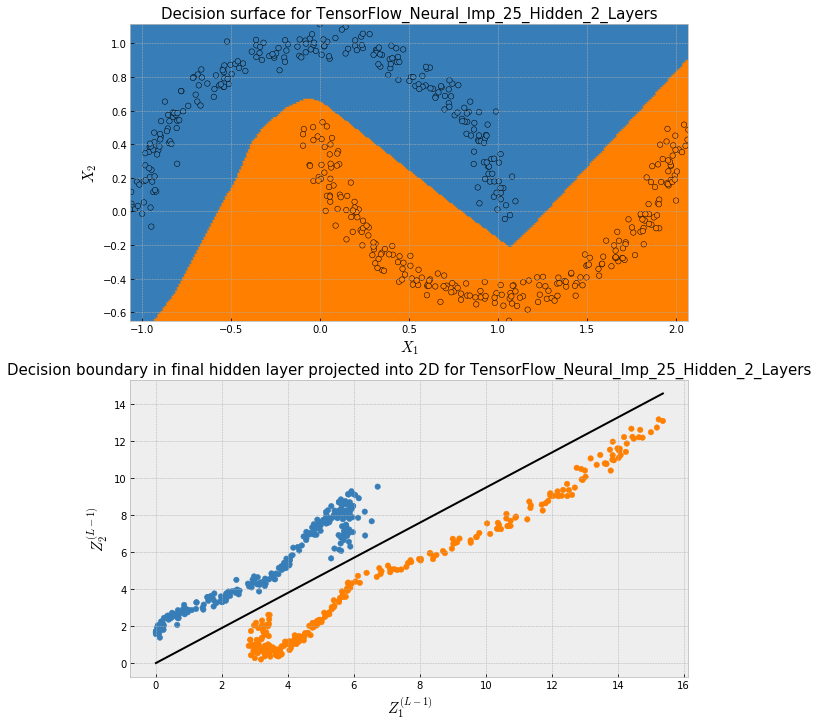

In [60]:
plot_decision_surface(X, Y, nnClassifierProjectTF25)

We've shown how adding more hidden nodes gives the model more dimensions into which it can separate the data or, equivalently, more hyperplanes in the input space to classify the data. We couldn't fully classify our original data with just 5 hidden nodes, but we managed it with 25.

Note that this is equivalent to the *kernel trick* used in SVM to help separate linearly non-seperable data. However, this step is very manual and forces the user to miraculously identify such a useful non-linear transformation. In the neural network formulation this transformation is learnt as part of the training.

Earlier we mentioned that *shallow* networks, those with only one hidden layer, are universal approximators to continuous functions. This implies that we can learn any function arbitrarily closely by using one hidden layer and enough hidden nodes. However, this result is not constructive: it doesn't specify how many nodes should be used. It also cannot guarantee that our optimisation algorithm will converge in finite time. In addition, this theorem does not address out-of-sample error, with experiments showing that one hidden layer often overfits to the training data.

Increasingly to learn more complex functions people turn to *deep* networks: more than one hidden layer. Intuitively it makes sense that with more hidden layers a network is able to partition the input feature space into more regions. In fact it can be shown that the number of regions grows exponentially with the number of layers. In addition, very recent work shows how deep networks prevent overfitting by using an implicit self-regularisation that exhibits similar behaviour to Tikhonov [[Martin & Mahoney](https://arxiv.org/pdf/1810.01075.pdf)].

For clarity we only used data with two input features, $F$, and two classes, $K$. However, our implementation is flexible enough to handle any $F$ and $K$. The below plots show the classification of 4 classes.

In [41]:
def make_swirls(n_samples: int, n_classes: int, noise: float, shuffle=True):
    
    n_samples_per_class=math.floor(n_samples / n_classes)
    n_samples = n_samples_per_class*n_classes
    
    X = np.zeros((n_samples, 2))
    Y = np.zeros(n_samples, dtype='int8')

    for i in range(n_classes):
        class_indices = range(n_samples_per_class*i, n_samples_per_class*(i+1))
        r = np.linspace(0.0, 1, n_samples_per_class)
        theta = np.linspace(i*5, (i+1)*5, n_samples_per_class) + np.random.randn(n_samples_per_class)*noise
        X[class_indices] = np.c_[r*np.sin(theta), r*np.cos(theta)]
        Y[class_indices] = i
    
    final_indices = [i for i in range(n_samples)]
    
    if shuffle:
        random.shuffle(final_indices)
    
    return (X[final_indices], Y[final_indices])

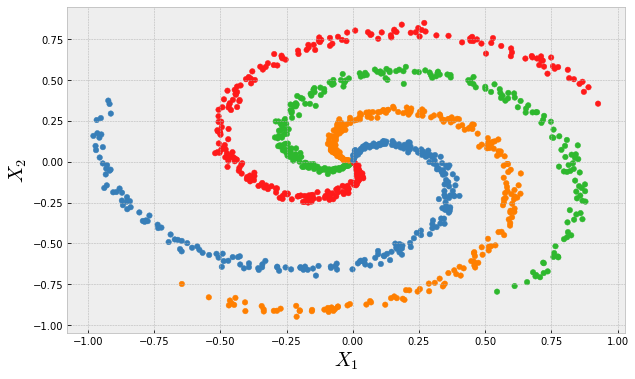

In [44]:
X_swirl, Y_swirl = make_swirls(n_samples=1000, n_classes=4, noise=0.1)
plot_data(X_swirl, Y_swirl)

In [63]:
nnClassifier40 = NeuralNetClassifier(name="Custom_Neural_Imp_40_Hidden", max_iter=5000, num_hidden_nodes=40)
nnClassifier40.train(X_swirl, Y_swirl)

iteration 0: loss 1.35773, accuracy 25.5%
iteration 50: loss 1.26587, accuracy 37.2%
iteration 100: loss 1.22021, accuracy 40.0%
iteration 150: loss 1.18627, accuracy 40.9%
iteration 200: loss 1.15791, accuracy 41.0%
iteration 250: loss 1.13401, accuracy 42.8%
iteration 300: loss 1.11269, accuracy 45.5%
iteration 350: loss 1.09297, accuracy 46.9%
iteration 400: loss 1.07457, accuracy 49.7%
iteration 450: loss 1.05689, accuracy 52.8%
iteration 500: loss 1.03962, accuracy 54.8%
iteration 550: loss 1.02259, accuracy 57.2%
iteration 600: loss 1.00567, accuracy 58.6%
iteration 650: loss 0.98882, accuracy 59.5%
iteration 700: loss 0.97195, accuracy 61.2%
iteration 750: loss 0.95514, accuracy 62.8%
iteration 800: loss 0.93847, accuracy 64.0%
iteration 850: loss 0.92187, accuracy 65.6%
iteration 900: loss 0.90546, accuracy 66.7%
iteration 950: loss 0.88932, accuracy 68.1%
iteration 1000: loss 0.87336, accuracy 70.0%
iteration 1050: loss 0.85768, accuracy 71.1%
iteration 1100: loss 0.84235, acc

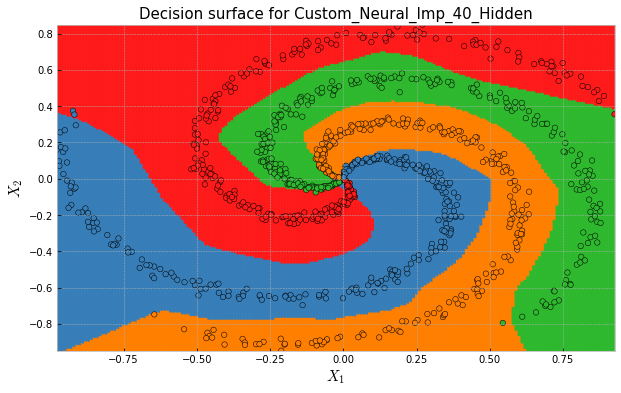

In [64]:
plot_decision_surface(X_swirl, Y_swirl, nnClassifier40, plot_boundary=False)